In [1]:
cd /home/karen/Documents/GitHub/Muscle_wasting

/home/karen/Documents/GitHub/Muscle_wasting


/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# USE CASE 1
- oNetwork: "/home/karen/Documents/GitHub/Muscle_wasting/network/Networks_CYJS/tf_network_ML_and_10_DE.cyjs"
- path_DDS_data: "/home/karen/Documents/GitHub/Muscle_wasting/data/join_dds.csv"
- path_tissue_data: "/home/karen/Documents/GitHub/Muscle_wasting/data/gene_tissue_Sarcopenia_relevant.csv"
- path_cell_type_data: "/home/karen/Documents/GitHub/Muscle_wasting/data/proportion_cell_type_div_Sarcopenia_relevant.csv"
- path_pathway_file: "/home/karen/Documents/GitHub/Muscle_wasting/data/join_pathway.csv"
- path_tf_file: "/home/karen/Documents/GitHub/Muscle_wasting/data/join_tf.csv"
- page_rank_cutoff: [0.95 0.99]
- coefficients: {'dds': 20, 'tissue': 1, 'cellular': 1, 'pathway_svd': 1, 'tf': 1, 'miR_enhancement':1}
--network_name UseCase1

In [2]:
def get_plot_enriched(selected_genes, title):
    enriched = dc.get_ora_df(
            df=selected_genes,
            net=msigdb,
            source='geneset',
            target='genesymbol'
        )
    pathway_df = enriched[enriched['FDR p-value'] < 0.1]
    pathway_df.index = pathway_df["Term"]
    #pathway_df.set_index("Term", inplace=True)  # Set "Term" as index
    enriched_pathways = pathway_df['Combined score']
    return plot_ora_results(pathway_df, top_n=10, figsize=(12, 6), scale_odds_ratio=.5, 
                     fontsize_title=12, fontsize_subtitle=12, fontsize_text=10,title=title)

In [3]:
import mirna_scoring.walking_network as wn
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mirna_scoring.mirna_impact as mis
import seaborn as sns
import mirna_scoring.mirna_influence_plots as mi_plot
import mirna_scoring.jupyter_functions as jf
from  mirna_scoring.score import *

/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from importlib import reload  # Python 3.4+
import mirna_scoring.mirna_impact as mis

In [5]:
from network.network_processing import load_graph

In [6]:
from mirkitten.plot_GSEA_ORA import plot_ora_results

In [7]:
import decoupler as dc
import os

In [8]:
session_name = 'UseCase_1'

Fisrt we create the output folder for the results

In [9]:
directory='mirna_scoring/results/'+session_name
if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory created successfully!")
else:
    print("Directory already exists!")

Directory already exists!


And we load the output form MiRNA Network

In [10]:
network = load_graph(f"network/Networks_pkl/complete_n_tf_mirnas__UseCase1_cutoff_0.95.pkl")
my_network = mis.mirna_network(network=network)

We can just use the function quick scoring, that will score each microRNA for:
- Influence on up and down regulated genes
- Number of Differentially express genes hit
- The weight of the node (calculated on miRKat Network)
- Random walk pathway influence.

This are factual values of the microRNA, there was already a filtering on mirKat Network

In [11]:
scores = my_network.quick_get_all_scores(steps=10, sample_size=10, dds_threshold=2, pathway_keywords=['ATP', 'MUSCLE', "MYO"])

In [12]:
#scores.sort_values(by=['de_count'], ascending = True)

To select the microRNAs, we see 3 factors
- How extreme are their values, if they have heavy outliers it gets added to the list
- Is the top performer on one of the categorties
- It is in the top for several 
- Has the most favorable up regulated genes activation
- Has the most favorable down regulated genes inhibition.

We then get the intersection

In [13]:

top_rows_extreme, row_scores_extreme = select_extreme_rows(scores, x=5, method='iqr')
top_rows_ranked, row_scores_top = select_top_ranked_rows(scores, x=5)
top_rows_ranked_normalized, row_scores_normalized = select_top_normalized_rows(scores, x=5)


In [14]:
mirnas = []
mirnas.extend(top_rows_extreme.index)
mirnas.extend(top_rows_ranked.index)
mirnas.extend(top_rows_ranked_normalized.index)


In [15]:

for comparison in my_network.get_all_available_combinations():
    mir = my_network.get_best_inhibitor_in_comparison(comparison)
    mirnas.append(mir)
    mir = my_network.get_best_activator_in_comparison(comparison)
    mirnas.append(mir)
    

In [16]:
mirnas = list(set(mirnas))
mirnas

['hsa-miR-126-3p',
 'hsa-miR-29a-3p',
 'hsa-miR-205-5p',
 'hsa-miR-200b-3p',
 'hsa-miR-106a-5p',
 'hsa-miR-200c-3p',
 'hsa-miR-20a-5p',
 'hsa-miR-1-3p',
 'hsa-miR-34a-5p',
 'hsa-miR-29b-3p',
 'hsa-miR-29c-3p',
 'hsa-miR-125a-5p',
 'hsa-miR-125b-5p',
 'hsa-miR-144-3p',
 'hsa-miR-17-5p']

Since many of the mirnas may behave the same, we cluster based on their impact on the genes (how often they reach the gene, if they rach with a -1 or 1) as shown in plot


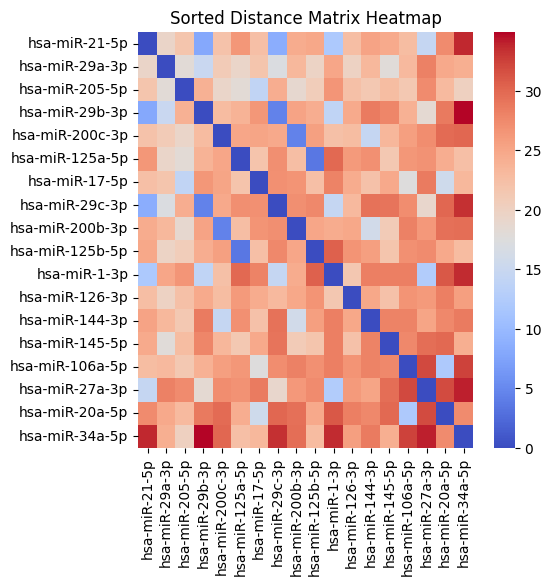

In [17]:
dist_df = my_network.get_mirnas_similarity()
mi_plot.plot_mirnas_similarirty(dist_df)


In [18]:
n_clusters= len(mirnas)//3
mirna_clusters = jf.cluster_mirnas(dist_matrix_square=dist_df, n_clusters=n_clusters)
minas_cluster = mirna_clusters.sort_values(by=["Cluster"])['Cluster']

Cluster labels:
 [1 3 1 1 2 2 2 0 0 1 3 4 3 4 3 3 1 0]


/home/karen/Documents/GitHub/Muscle_wasting/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:310: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [19]:
clustered_mirnas = {}
for mirna in mirnas:
    if mirna in minas_cluster.index:
        cluster = minas_cluster[mirna]
        if cluster not in clustered_mirnas:
            cluster=int(cluster)
            clustered_mirnas[cluster] = []
        clustered_mirnas[cluster].append(mirna)
clustered_mirnas

{3: ['hsa-miR-126-3p', 'hsa-miR-29a-3p', 'hsa-miR-205-5p', 'hsa-miR-34a-5p'],
 0: ['hsa-miR-200b-3p', 'hsa-miR-200c-3p', 'hsa-miR-144-3p'],
 2: ['hsa-miR-106a-5p', 'hsa-miR-20a-5p', 'hsa-miR-17-5p'],
 1: ['hsa-miR-1-3p', 'hsa-miR-29b-3p', 'hsa-miR-29c-3p'],
 4: ['hsa-miR-125a-5p', 'hsa-miR-125b-5p']}

Now that the mirnas are assiged to a cluster, we can proceed with the plot of the smaller networks.
This will be the microRNAs and the genes they reached on the random walk. 
On the plot we also add the pathway enrichment of the targets reached for that mirna.
This it done in 2 ways, mirna indoviodually and by cluster.


In [20]:

if "msigdb.csv" in os.listdir('mirkitten/data'):
    msigdb = pd.read_csv('mirkitten/data/msigdb.csv', index_col = 0)
msigdb.index = msigdb['genesymbol']
sel_db = ['go_molecular_function',
                      'go_cellular_component',
                      'go_biological_process',
                      'reactome_pathways',
                      'kegg_pathways', 'hallmark']
msigdb =msigdb[msigdb['collection'].isin(sel_db)]
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
      

mirna_scoring/results/UseCase_1/hsa-miR-126-3p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-126-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-29a-3p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-29a-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-205-5p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-205-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-200b-3p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-200b-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-106a-5p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-106a-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-200c-3p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-200c-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-20a-5p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-20a-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-1-3p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-1-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-34a-5p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-34a-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-29b-3p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-29b-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-29c-3p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-29c-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-125a-5p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-125a-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-125b-5p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-125b-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-144-3p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-144-3p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


mirna_scoring/results/UseCase_1/hsa-miR-17-5p.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-17-5p.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


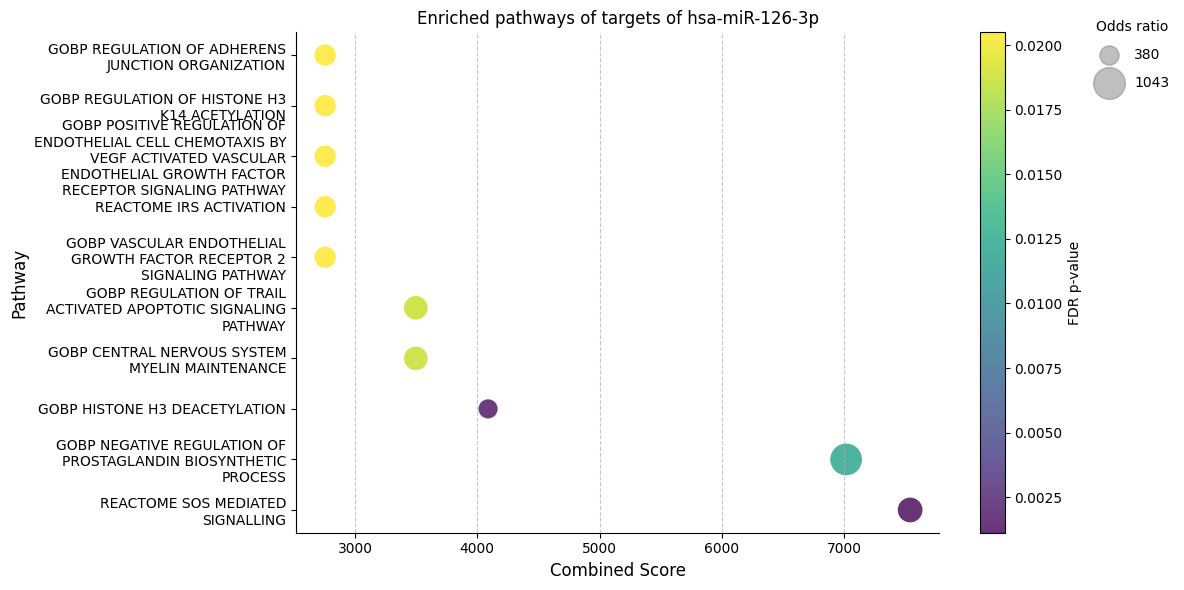

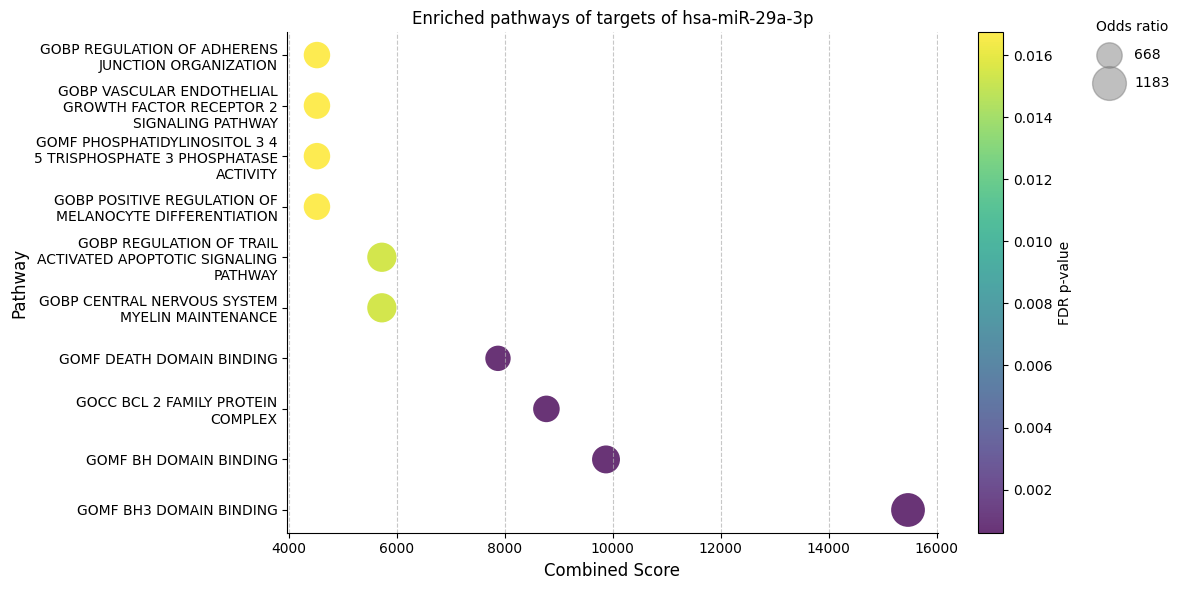

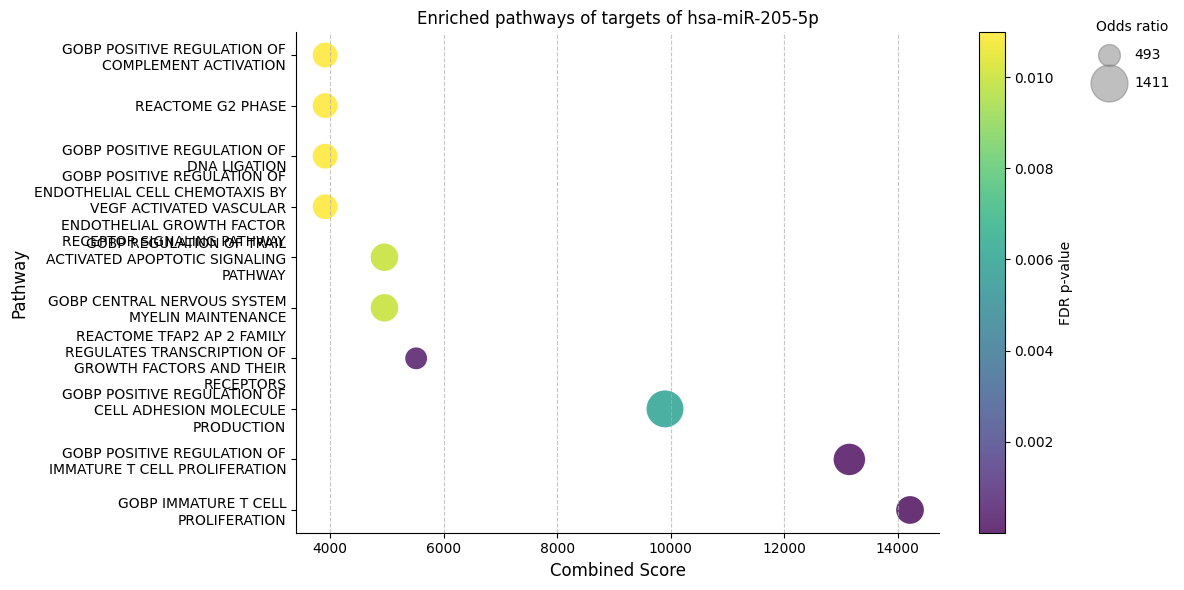

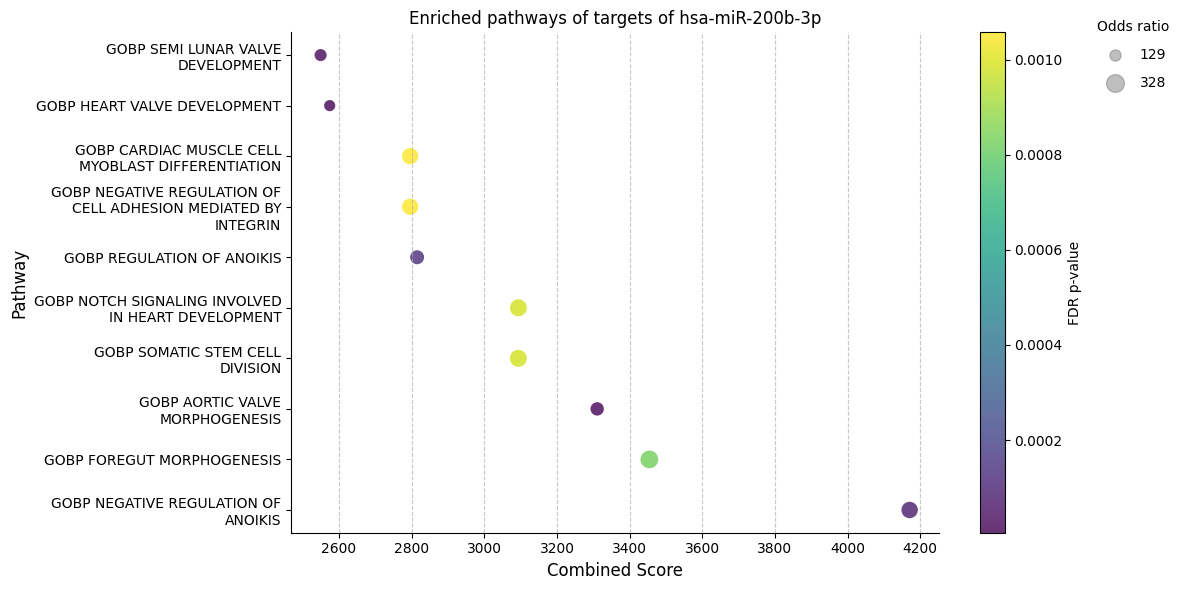

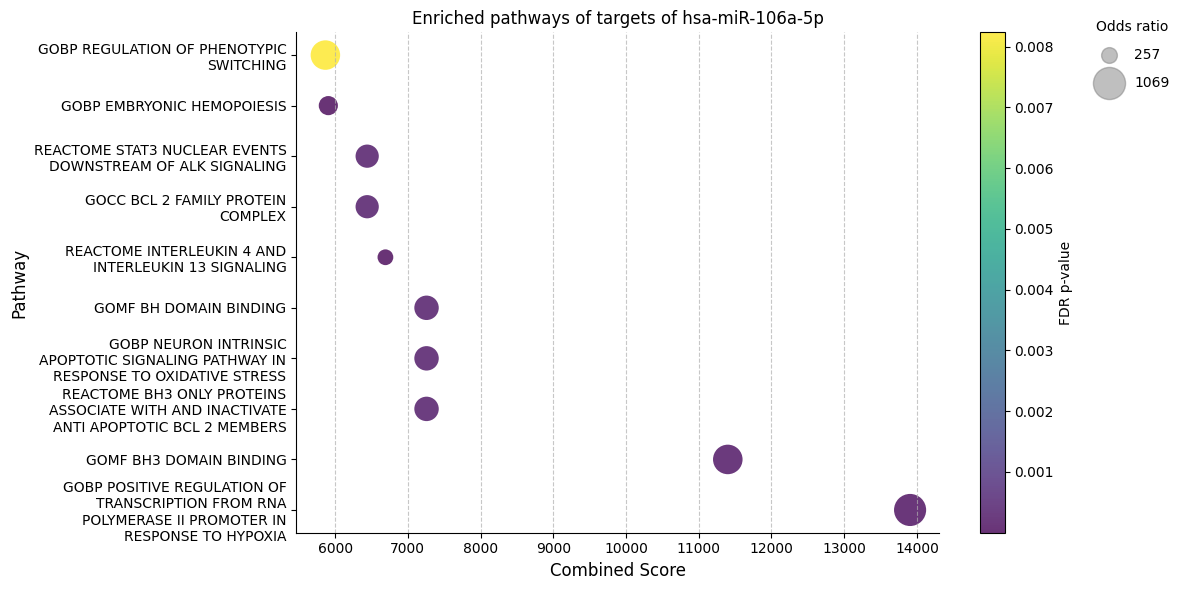

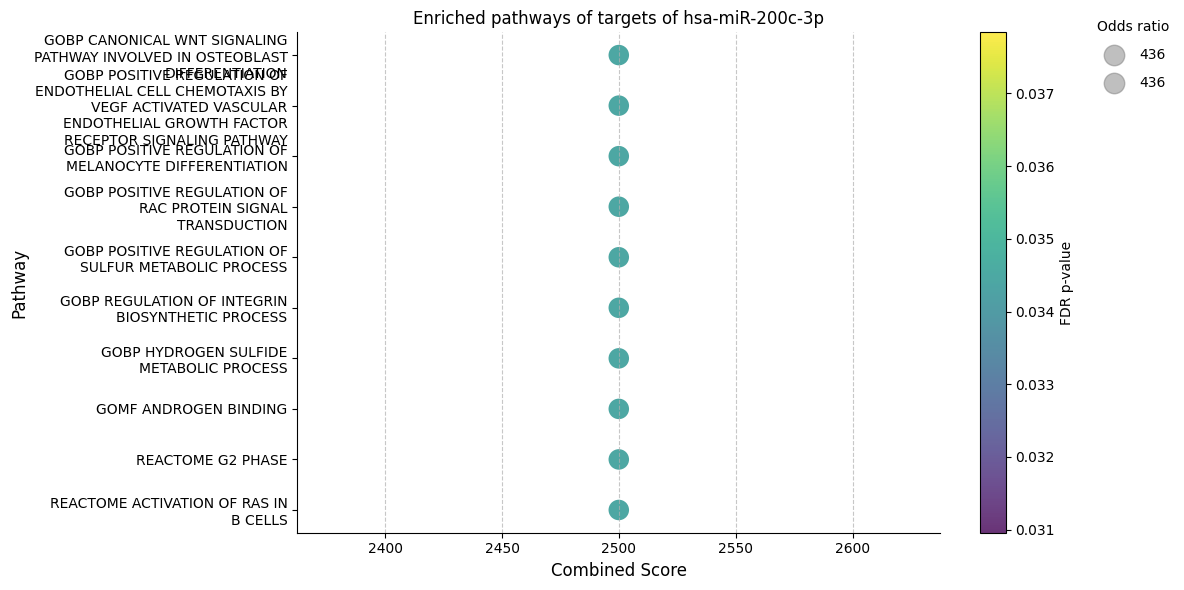

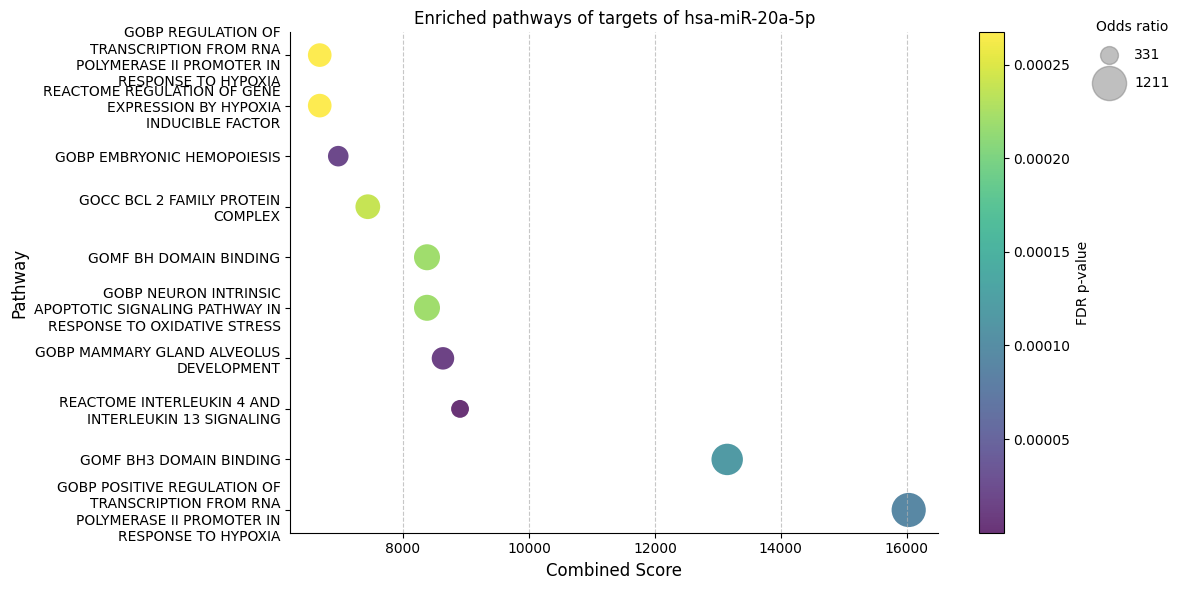

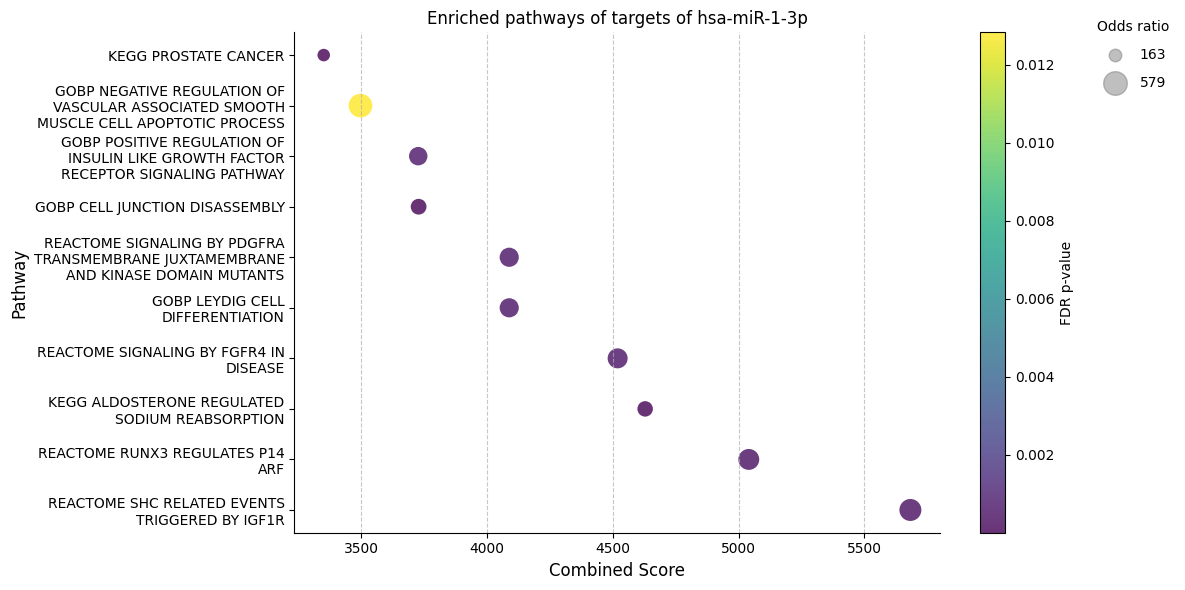

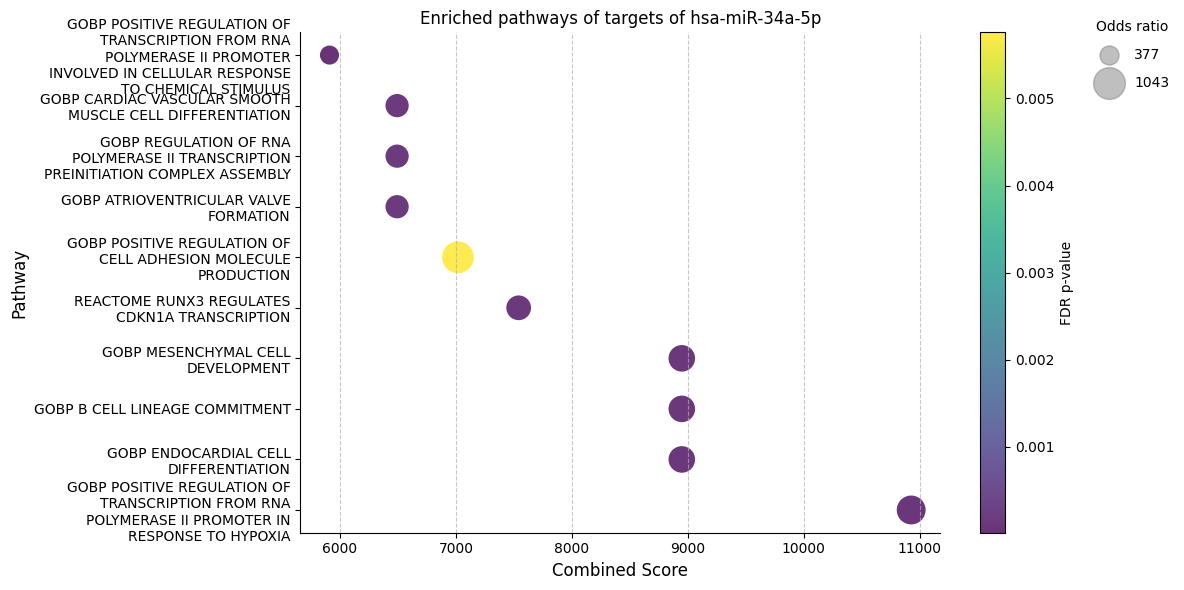

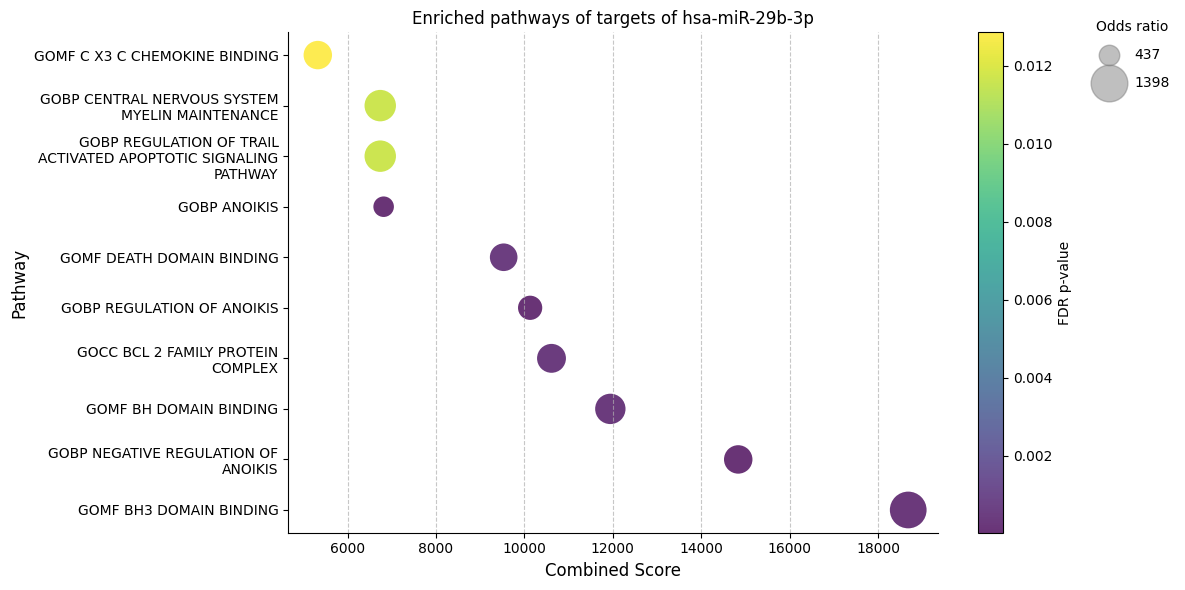

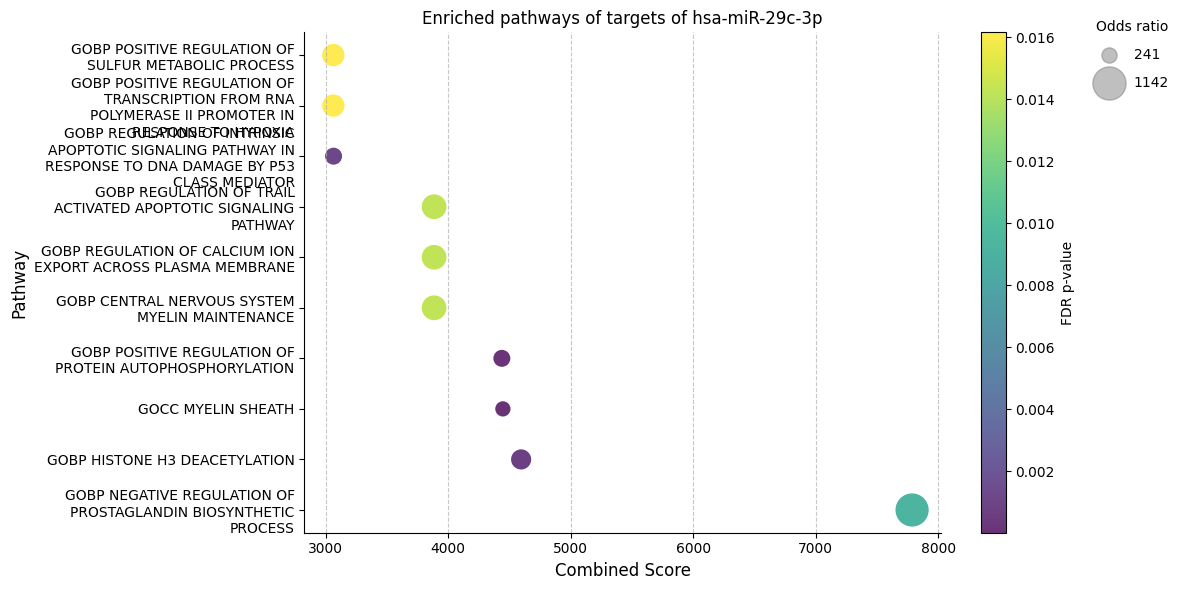

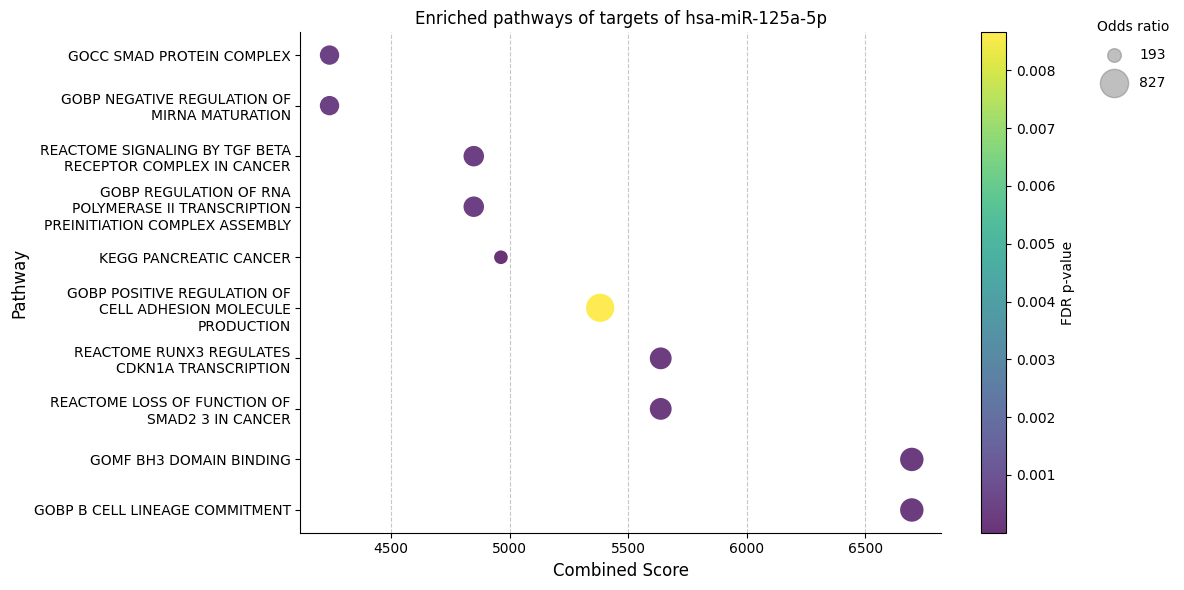

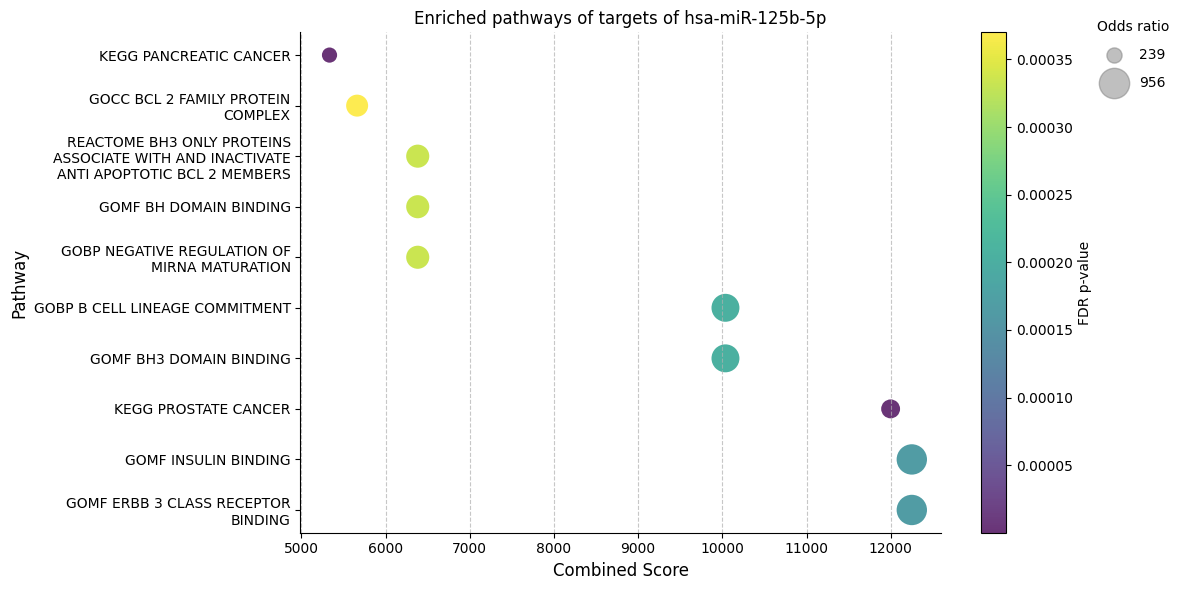

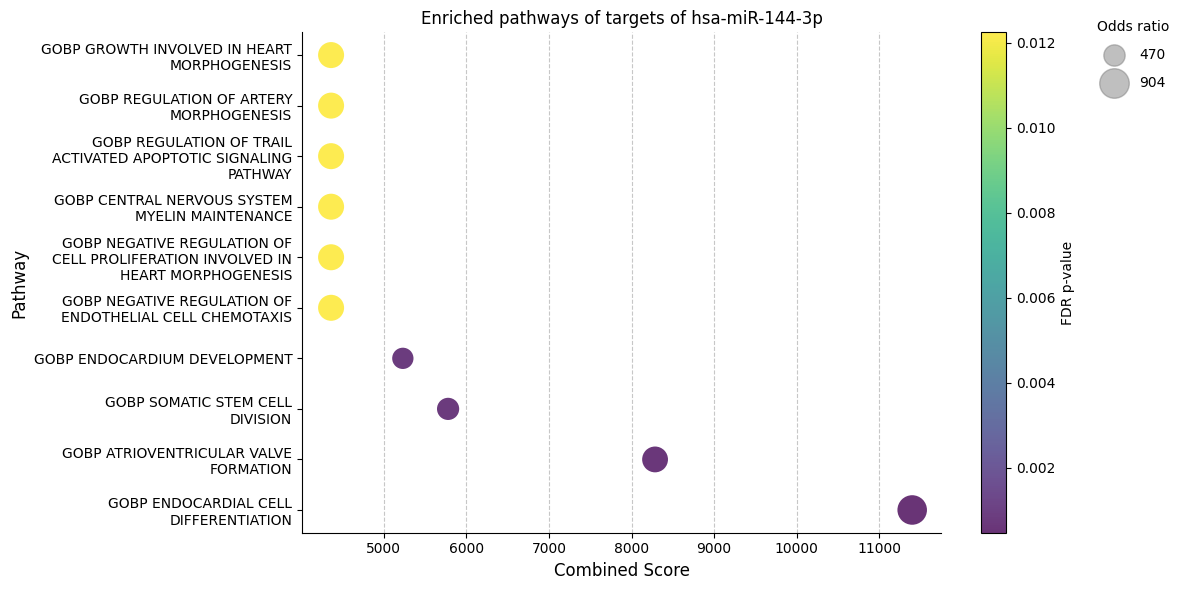

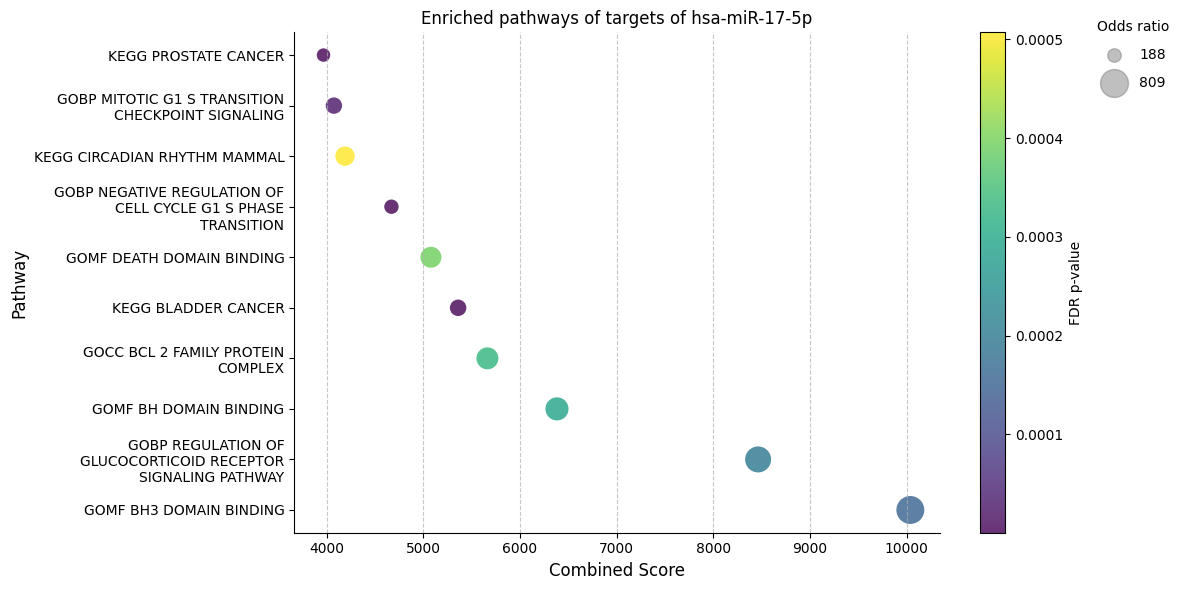

In [21]:
genes = []
for mirna in mirnas:
    paths = my_network.mirnas_paths[mirna]
    sub_network=[]
    for path in paths:
        sub_network.extend(path)
        genes.extend(path)
    sub_network=list(set(sub_network))
    #mi_plot.draw_network(G=my_network.network, node_list = sub_network, name= mirna, save_path='mirna_scoring/sub_plots')
    html_file = mi_plot.generate_html_network_report(network=my_network.network, selected_nodes=sub_network, name=mirna, save_path=directory)
    #fig, ax = get_plot_enriched(sub_network, f"Enriched pathways of targets of {mirna}")
    fig, ax = get_mirna_target_enriched(selected_genes=sub_network, title=f"Enriched pathways of targets of {mirna}", msigdb=msigdb)
    image_file = html_file.split('/')[-1]
    html_image_path = f'{image_file}_PathwayEnriched.png'
    image_file = f'{directory}/{image_file}_PathwayEnriched.png'
    fig.savefig(image_file, dpi=300, bbox_inches='tight')
    
    with open(html_file, "r") as file:
        html_content = file.read()

    # Append the image tag to the HTML
    html_content += f"""
    <h2>Enriched Pathways</h2>
    <img src="{html_image_path}" alt="Enriched Pathways">
    """
    
    # Save the modified HTML file
    with open(html_file, "w") as file:
        file.write(html_content)

30
mirna_scoring/results/UseCase_1/hsa-miR-34a-5p_cluster_3.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-34a-5p_cluster_3.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


28
mirna_scoring/results/UseCase_1/hsa-miR-144-3p_cluster_0.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-144-3p_cluster_0.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


20
mirna_scoring/results/UseCase_1/hsa-miR-17-5p_cluster_2.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-17-5p_cluster_2.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


23
mirna_scoring/results/UseCase_1/hsa-miR-29c-3p_cluster_1.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-29c-3p_cluster_1.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


19
mirna_scoring/results/UseCase_1/hsa-miR-125b-5p_cluster_4.html
Saved on mirna_scoring/results/UseCase_1/hsa-miR-125b-5p_cluster_4.html


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


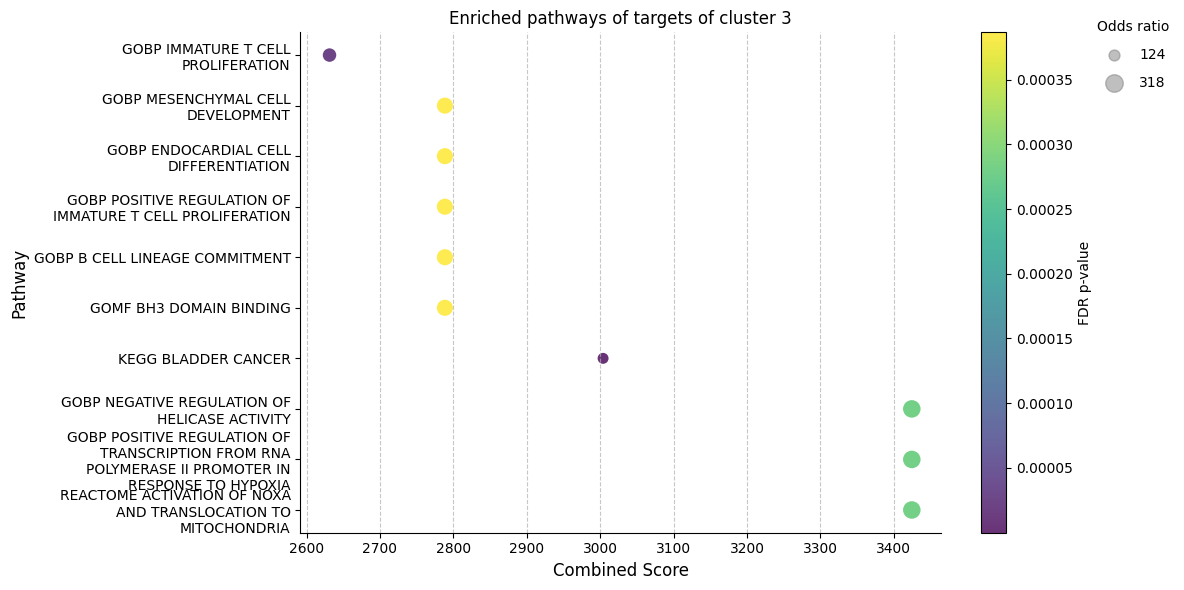

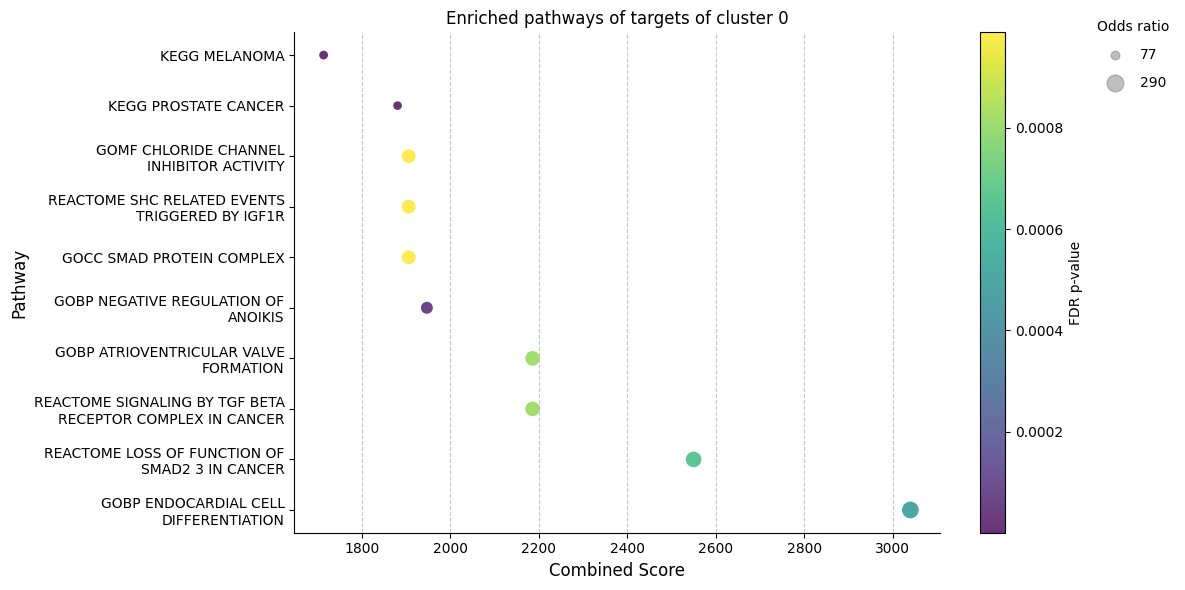

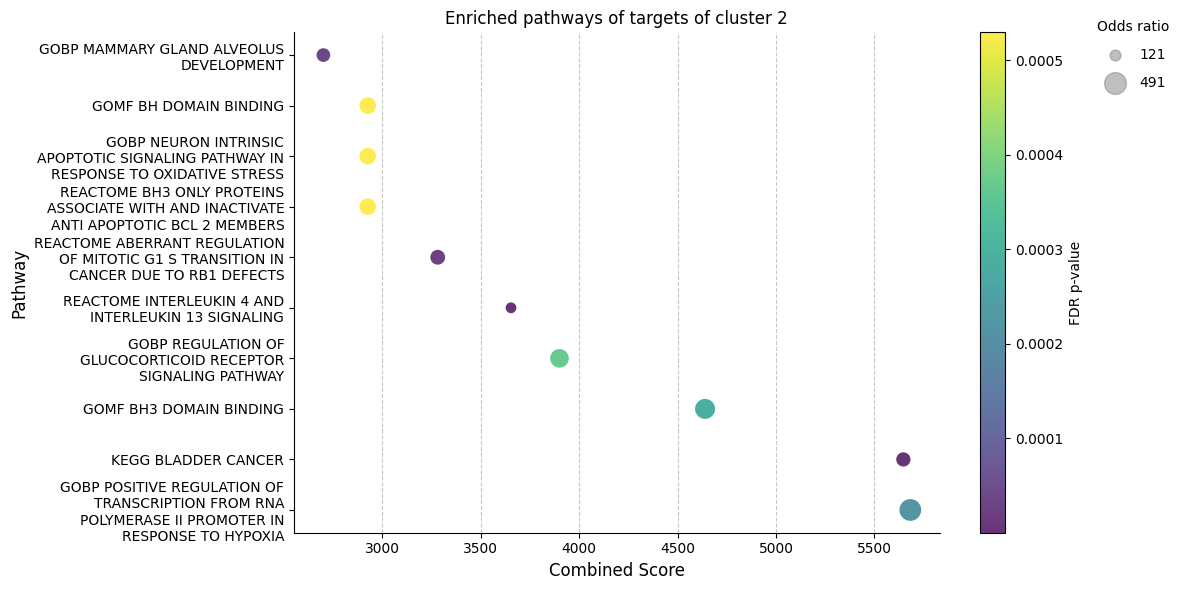

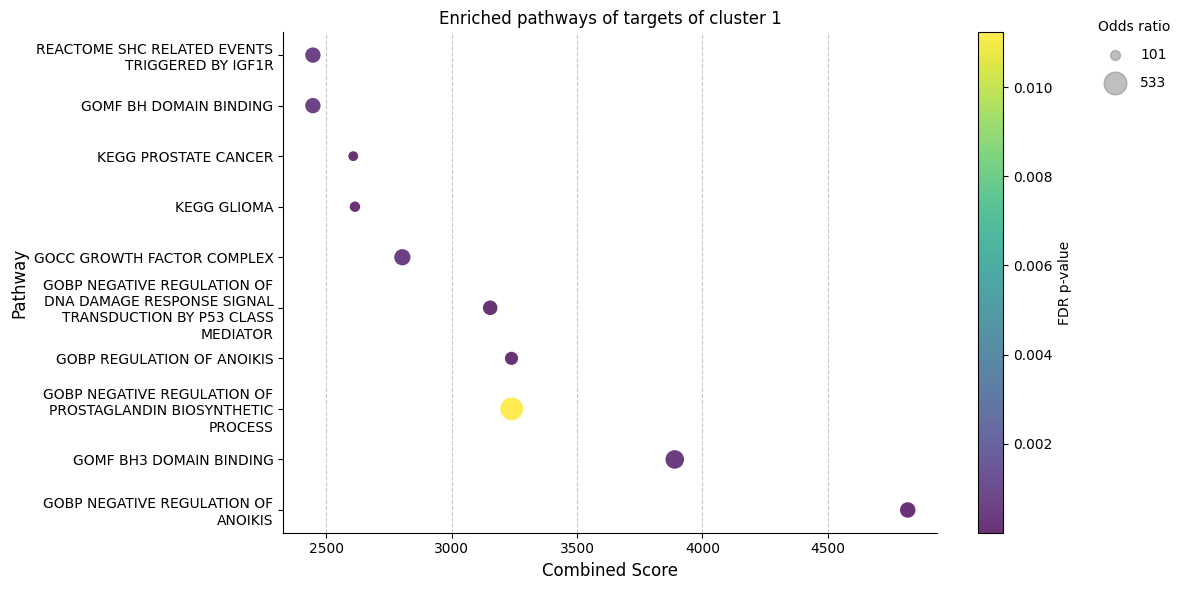

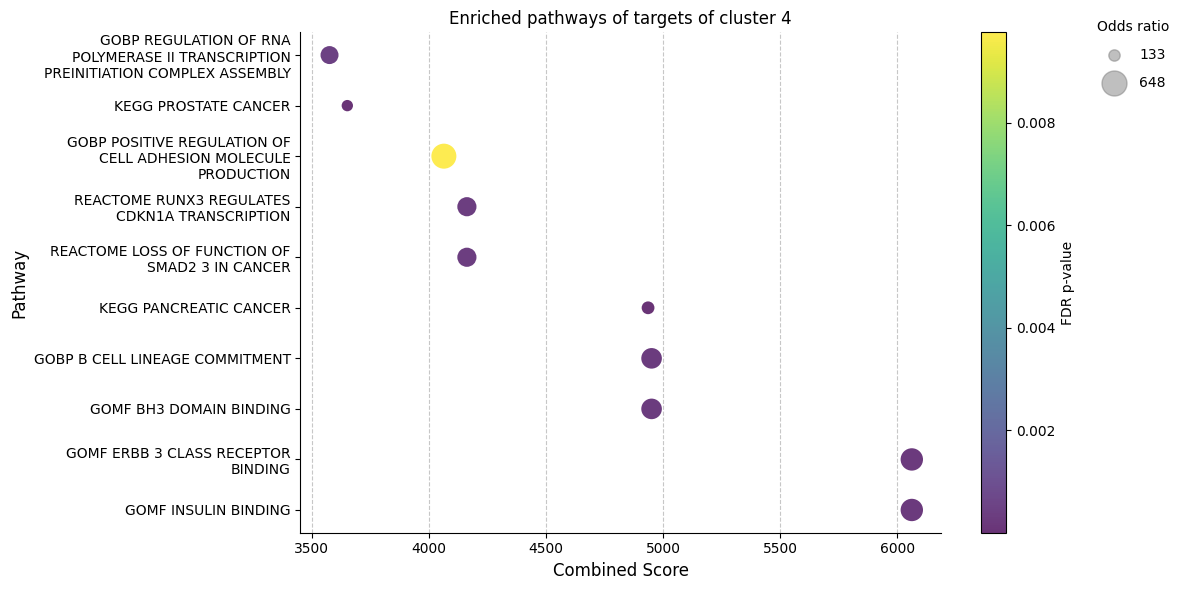

In [22]:
for cluster, mirnas in clustered_mirnas.items():
    sub_network_cluster=[]
    impacts=[]
    for mirna in mirnas:
        paths = my_network.mirnas_paths[mirna]
        for path in paths:
            sub_network_cluster.extend(path)
        impact = my_network.influence_sum_df.loc[mirna]
        impacts.append(impact)
    sub_network_cluster=list(set(sub_network_cluster))
    impacts = pd.DataFrame(impacts)
    genes = [gene for gene in sub_network_cluster if gene in impacts.columns]
    impacts = impacts[genes]
    impacts = impacts.reset_index()
    print(len(sub_network_cluster))
    mi_plot.generate_html_network_report(network=my_network.network, selected_nodes=sub_network_cluster, name=mirna+f"_cluster_{cluster}",influences=impacts.round(3), save_path=directory)
    #mi_plot.draw_network(G=my_network.network, node_list = sub_network_cluster, name= mirna+f"_cluster_{cluster}", save_path='mirna_scoring/sub_plots')
    html_file = f"{directory}/{mirna}_cluster_{cluster}.html"
    fig, ax = get_plot_enriched(sub_network_cluster, f"Enriched pathways of targets of cluster {cluster}")
    image_file = html_file.split('/')[-1]
    html_image_path = f'{image_file}_PathwayEnriched.png'
    image_file = f'{directory}/{image_file}_PathwayEnriched.png'
    fig.savefig(image_file, dpi=300, bbox_inches='tight')
    
    with open(html_file, "r") as file:
        html_content = file.read()

    # Append the image tag to the HTML
    html_content += f"""
    <h2>Enriched Pathways</h2>
    <img src="{html_image_path}" alt="Enriched Pathways">
    """
    
    # Save the modified HTML file
    with open(html_file, "w") as file:
        file.write(html_content)

In [23]:
genes = list(set(genes))

If the user desires to see the genes selected on the output of miRKat Network, it can be done using the filters, the program already gives the filter to use, just to copy and paste :)

In [24]:
jf.get_cytoscape_filter_from_list(genes)

'(MCL1)|(FBXO32)|(IGF1R)|(E2F3)|(ANKRD1)|(SMAD4)|(BCL2)|(PIK3R1)|(SPARC)|(HSP90AB1)|(NPPA)|(ERBB2)|(TP53)|(SMAD2)|(HMGB1)|(IL1B)|(STAT3)|'

Finally, we can have a look on the enriched pathways on the network overall

In [25]:
enriched = dc.get_ora_df(
            df=genes,
            net=msigdb,
            source='geneset',
            target='genesymbol'
        )

In [26]:
pathway_df = enriched[enriched['FDR p-value'] < 0.1]
pathway_df.index = pathway_df["Term"]
#pathway_df.set_index("Term", inplace=True)  # Set "Term" as index
enriched_pathways = pathway_df['Combined score']

In [27]:
enriched_pathways

Term
GOBP_ACTIN_FILAMENT_BASED_PROCESS                                  44.834599
GOBP_ACTIN_FILAMENT_ORGANIZATION                                   21.297983
GOBP_ACTIVATED_T_CELL_PROLIFERATION                               123.673116
GOBP_ACTIVATION_OF_IMMUNE_RESPONSE                                 46.730859
GOBP_ACTIVIN_RECEPTOR_SIGNALING_PATHWAY                           518.157837
                                                                    ...     
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_PLURIPOTENT_STEM_CELLS    1989.367172
REACTOME_UB_SPECIFIC_PROCESSING_PROTEASES                         170.668055
REACTOME_UPTAKE_AND_ACTIONS_OF_BACTERIAL_TOXINS                   228.590036
REACTOME_UPTAKE_AND_FUNCTION_OF_DIPHTHERIA_TOXIN                 1476.660894
REACTOME_YAP1_AND_WWTR1_TAZ_STIMULATED_GENE_EXPRESSION            511.983002
Name: Combined score, Length: 2066, dtype: float64

In [28]:
pathway_df

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
Term,,,,,,,,
GOBP_ACTIN_FILAMENT_BASED_PROCESS,GOBP_ACTIN_FILAMENT_BASED_PROCESS,793,0.005044,0.003862,0.015027,8.068683,44.834599,ANKRD1;BCL2;PIK3R1;SMAD4
GOBP_ACTIN_FILAMENT_ORGANIZATION,GOBP_ACTIN_FILAMENT_ORGANIZATION,437,0.004577,0.052184,0.073943,7.212350,21.297983,BCL2;PIK3R1
GOBP_ACTIVATED_T_CELL_PROLIFERATION,GOBP_ACTIVATED_T_CELL_PROLIFERATION,47,0.021277,0.039223,0.059971,38.188517,123.673116,HMGB1
GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,GOBP_ACTIVATION_OF_IMMUNE_RESPONSE,490,0.006122,0.007695,0.022404,9.601287,46.730859,BCL2;HMGB1;IL1B
GOBP_ACTIVIN_RECEPTOR_SIGNALING_PATHWAY,GOBP_ACTIVIN_RECEPTOR_SIGNALING_PATHWAY,45,0.044444,0.000659,0.004127,70.739100,518.157837,SMAD2;SMAD4
...,...,...,...,...,...,...,...,...
REACTOME_TRANSCRIPTIONAL_REGULATION_OF_PLURIPOTENT_STEM_CELLS,REACTOME_TRANSCRIPTIONAL_REGULATION_OF_PLURIPO...,31,0.096774,0.000002,0.000068,153.022989,1989.367172,SMAD2;SMAD4;STAT3
REACTOME_UB_SPECIFIC_PROCESSING_PROTEASES,REACTOME_UB_SPECIFIC_PROCESSING_PROTEASES,205,0.014634,0.000649,0.004115,23.251699,170.668055,SMAD2;SMAD4;TP53
REACTOME_UPTAKE_AND_ACTIONS_OF_BACTERIAL_TOXINS,REACTOME_UPTAKE_AND_ACTIONS_OF_BACTERIAL_TOXINS,29,0.034483,0.024376,0.044346,61.545455,228.590036,HSP90AB1


/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


(<Figure size 1200x800 with 2 Axes>,
 <Axes: title={'center': 'Top 10 ORA Results by Combined Score'}, xlabel='Combined Score', ylabel='Pathway'>)

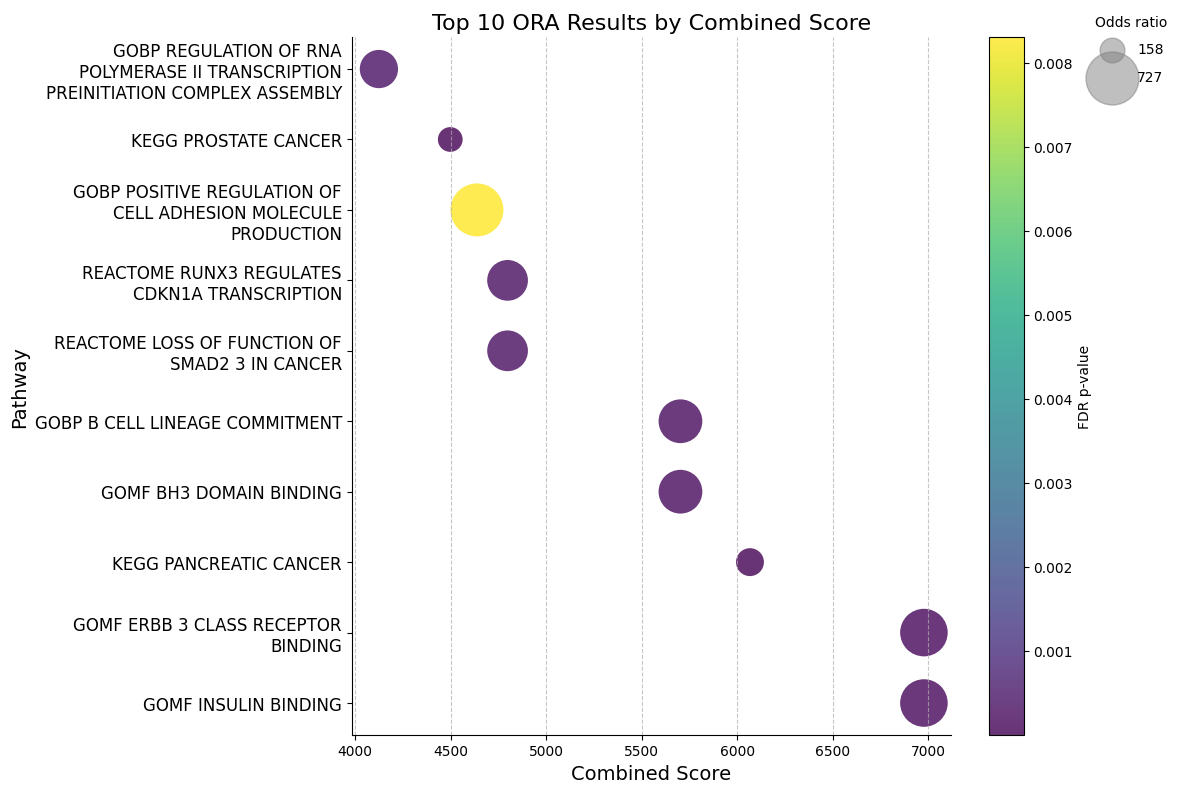

In [29]:
plot_ora_results(pathway_df, top_n=10, figsize=(12, 8), scale_odds_ratio=2, 
                     fontsize_title=16, fontsize_subtitle=14, fontsize_text=12,)

In [30]:
pathway_df_no_cancer = pathway_df[~pathway_df['Term'].str.contains('cancer', case=False)]

/home/karen/Documents/GitHub/Muscle_wasting/mirkitten/plot_GSEA_ORA.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ora_top['Term'], fontsize=fontsize_text)


(<Figure size 1000x600 with 2 Axes>,
 <Axes: title={'center': 'Top 10 ORA Results by Combined Score'}, xlabel='Combined Score', ylabel='Pathway'>)

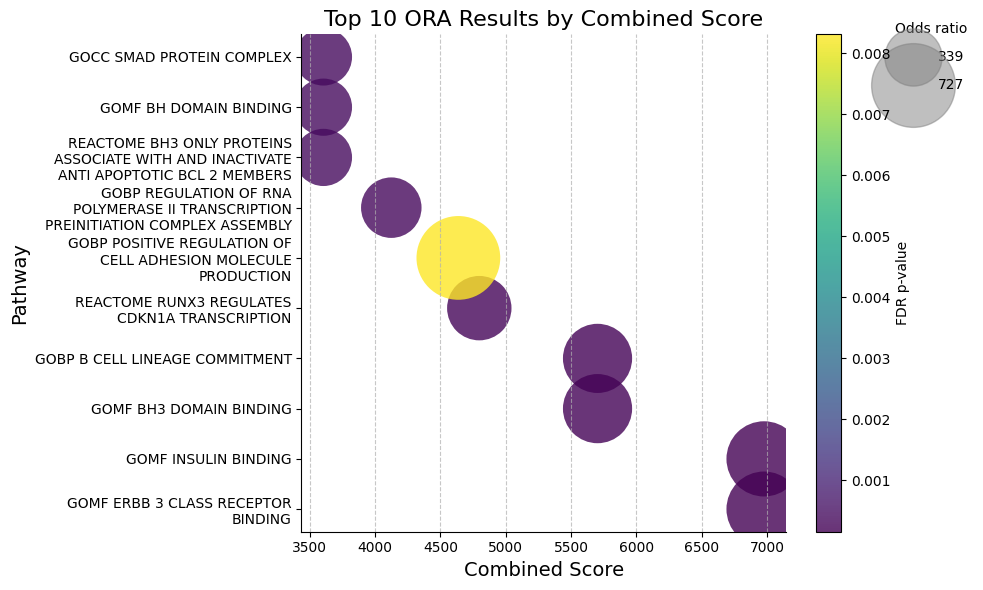

In [31]:
plot_ora_results(pathway_df_no_cancer, top_n=10, figsize=(10, 6), scale_odds_ratio=5, 
                     fontsize_title=16, fontsize_subtitle=14, fontsize_text=10,)

Plot the clusters

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Compute t-SNE embedding
tsne = TSNE(n_components=2, perplexity=30, random_state=42, metric="precomputed")
tsne_results = tsne.fit_transform(dist_df)

# Create a dataframe with t-SNE results and cluster labels
plot_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'], index=dist_df.index)
plot_df['Cluster'] = mirna_clusters['Cluster']

# Plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Cluster', data=plot_df, palette='tab10', alpha=0.7)
plt.title("t-SNE Visualization of Spectral Clustering")
plt.legend(title="Cluster")
plt.show()


ValueError: perplexity must be less than n_samples

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Compute UMAP embedding
reducer = umap.UMAP(metric="precomputed", random_state=42)
embedding = reducer.fit_transform(dist_df)

# Create a dataframe with UMAP results and cluster labels
plot_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'], index=dist_df.index)
plot_df['Cluster'] = mirna_clusters['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='UMAP1', y='UMAP2', hue='Cluster', data=plot_df, palette='tab10', alpha=0.7)

# Add labels for each miRNA
for i, txt in enumerate(plot_df.index):
    plt.annotate(txt, (plot_df['UMAP1'][i], plot_df['UMAP2'][i]), fontsize=8, alpha=0.7)

plt.title("UMAP Visualization of Spectral Clustering")
plt.legend(title="Cluster", bbox_to_anchor=(1, 1))
plt.show()
